In [1]:
import math
from qiskit import QuantumCircuit

In [2]:
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [4]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
backend.name

'ibm_brisbane'

In [5]:
# getting the quantum circuit representing the grover oracle

def grover_oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0])

    qc=QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits-1, 1), inplace=True)
        qc.x(zero_inds)

    return qc 

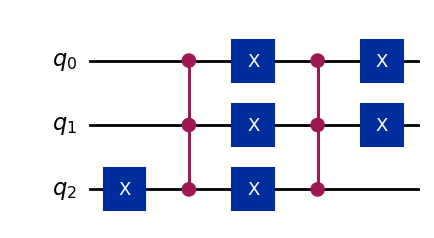

In [6]:
# Specific Grover's instance

marked_states = ["011", "100"]
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

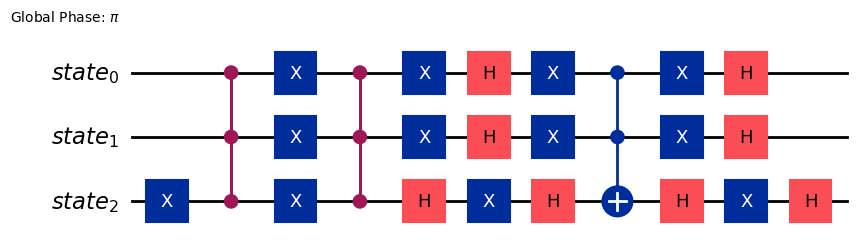

In [7]:
# Grover Operator

grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [8]:
# No of grover iterations
optimal_num_iterations = math.floor(math.pi/(4*math.asin(math.sqrt(len(marked_states)/2**grover_op.num_qubits))))

In [9]:
optimal_num_iterations

1

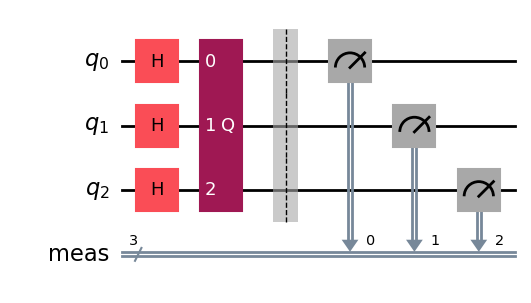

In [10]:
# Full Grover Circuit
qc=QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)

qc.measure_all()
qc.draw(output="mpl", style="iqp")

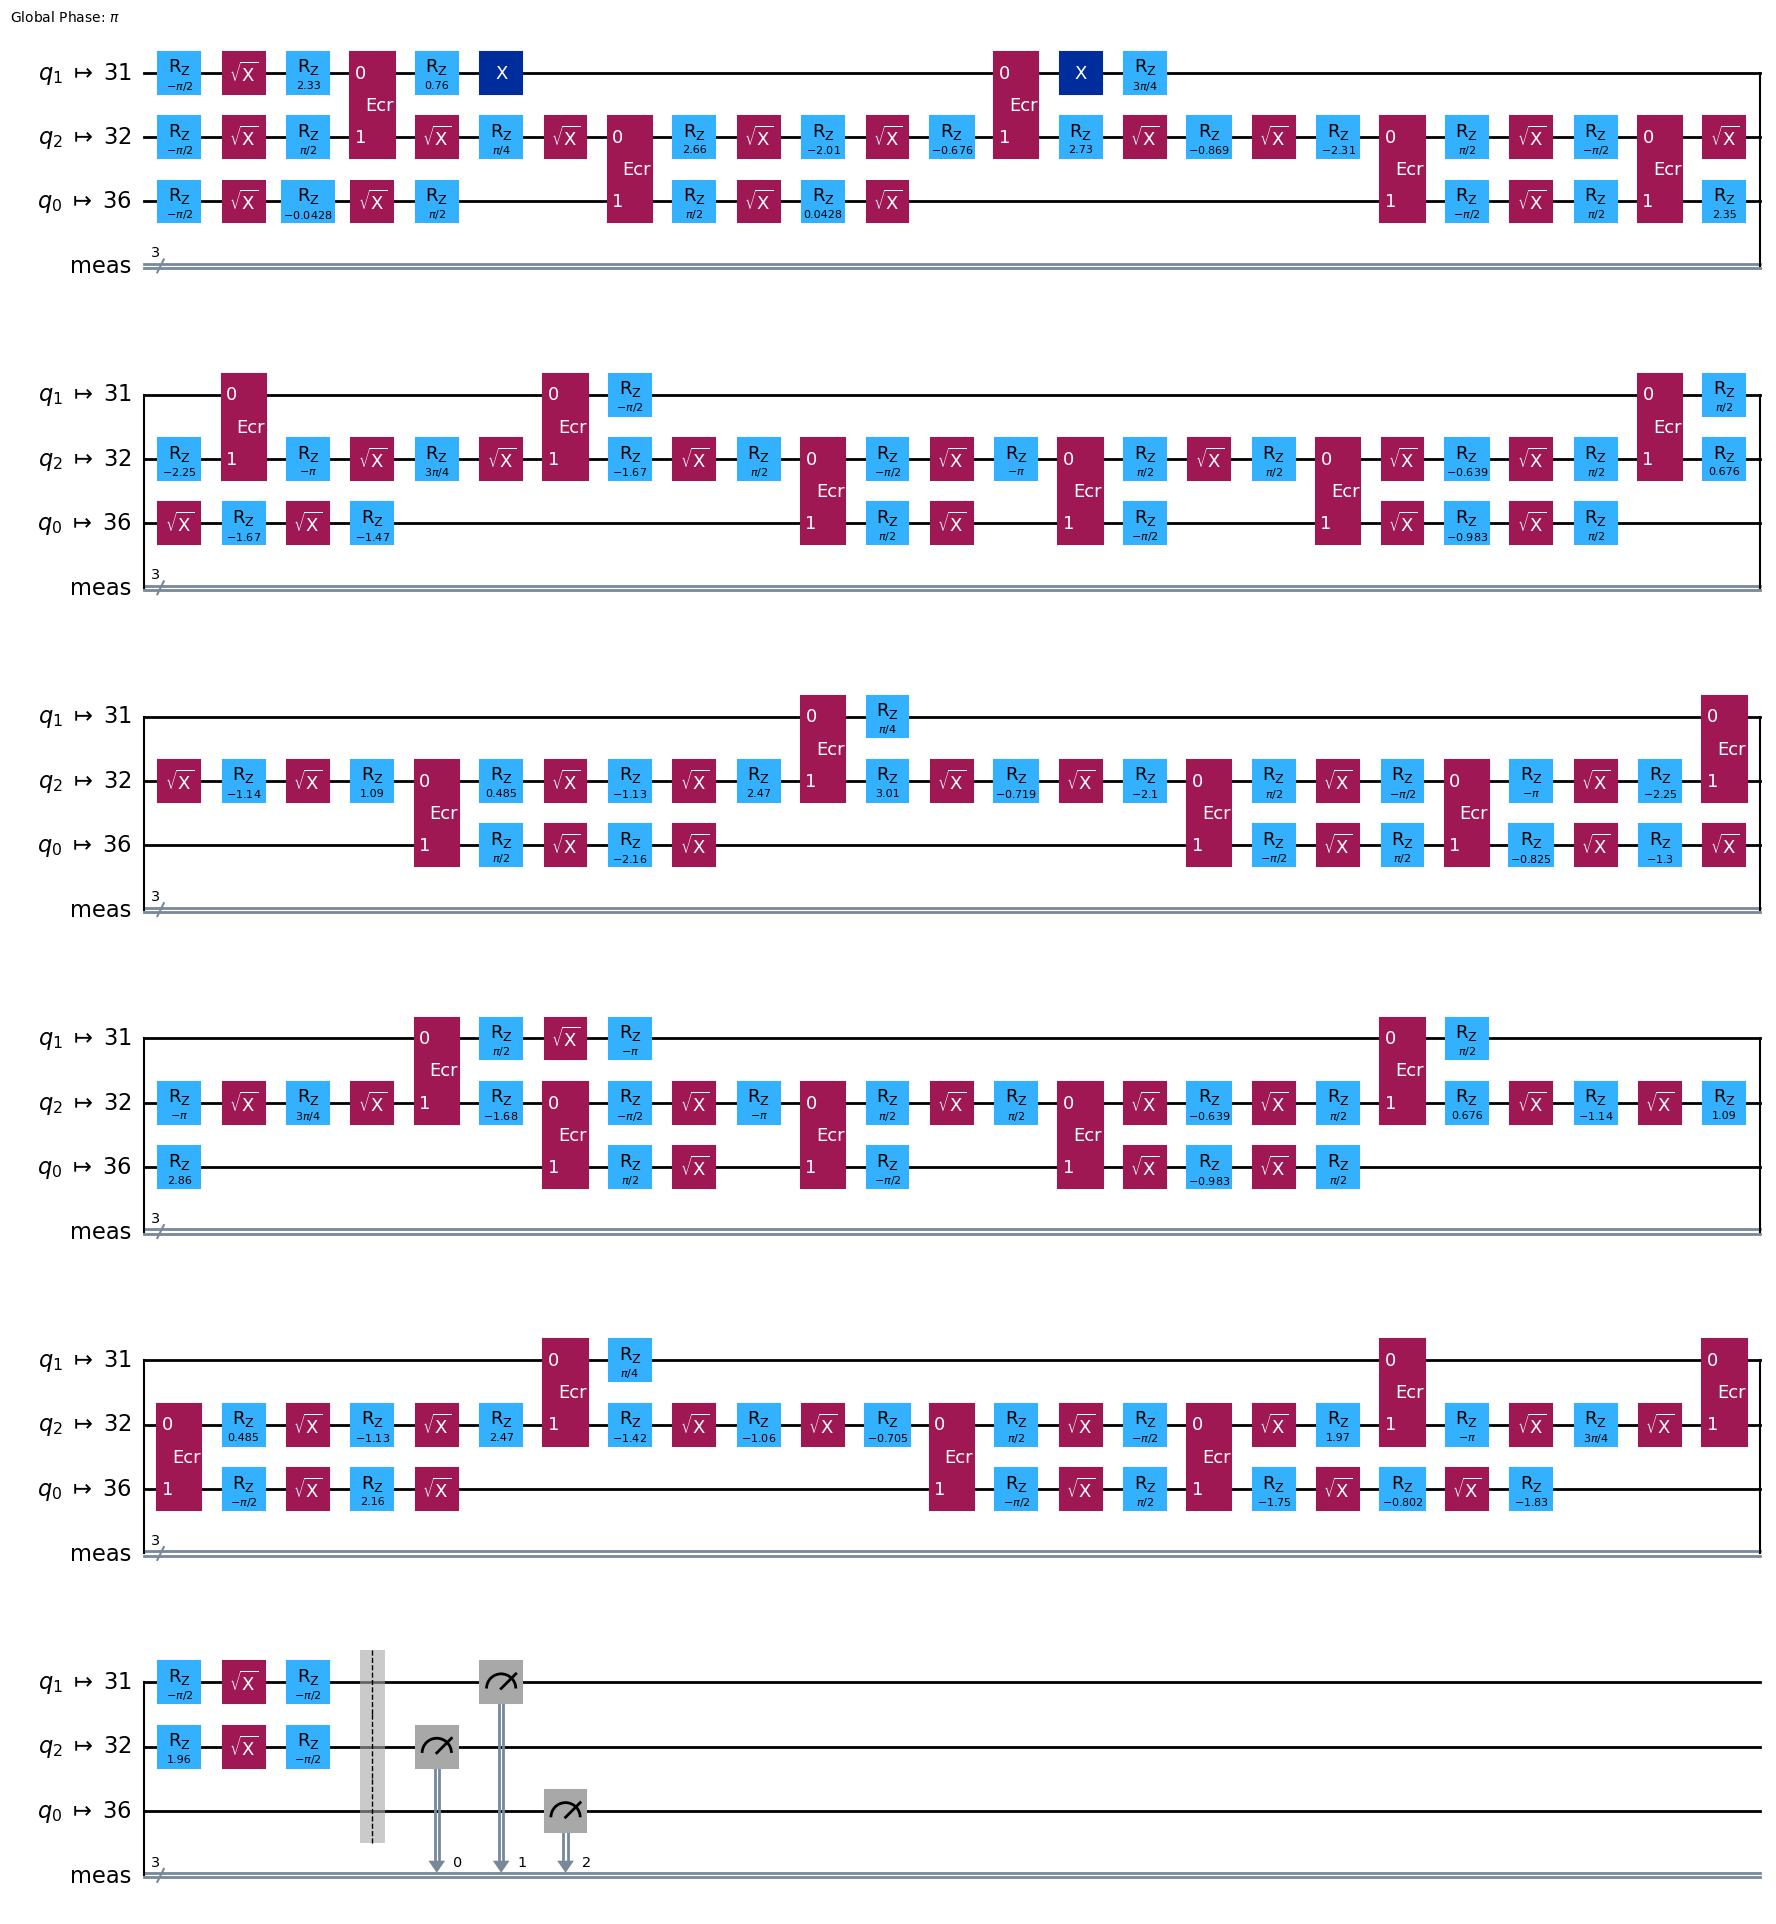

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires = False, style="iqp")

In [12]:
# Execute using Primitives

sampler=Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

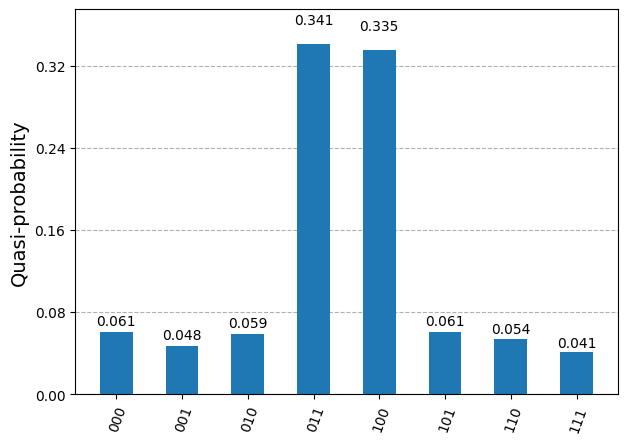

In [13]:
# Post Process
plot_distribution(dist)

In [14]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

In [15]:
import qiskit
qiskit.version.get_version_info()

'1.1.0'